In [270]:
import collections
import matplotlib.pyplot as plt
import numpy as np
import requests
import base64
import io
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw
from PIL import ImageOps

USERNAME = 'test1294'
CHALLENGE_URL = 'https://captcha.delorean.codes/u/{}/challenge'.format(
    USERNAME)

ALPHABET = list('abcdefghijklmnopqrstuvwxyz0123456789')


def get_captchas():
    return requests.get(CHALLENGE_URL).json()['images']


def decode_image(captcha):
    return plt.imread(io.BytesIO(base64.b64decode(captcha['jpg_base64'])), format='jpg')


def rgb2gray(rgb):
    return np.dot(rgb[..., :3], [0.299, 0.587, 0.114])


def gray2bw(gray, threshold=200):
    return np.where(gray < threshold, 0, 255)


def get_background(cache=[]):
    if cache:
        return cache[0]
    captchas = get_captchas()
    img = np.average([rgb2gray(decode_image(c))
                      for c in captchas[:300]], axis=0)
    img = gray2bw(img)
    cache.append(img)
    return img


LetterConfig = collections.namedtuple('LetterConfig', ['letter', 'x', 'y', 'rotation', 'pos'])


def render_captcha(text_config, draw_background=True):
    background = get_background()
    img = Image.fromarray(np.uint8(background) * draw_background, 'L')
    font = ImageFont.truetype('OpenSans-Bold.ttf', 24)
    for config in text_config:
        patch = Image.new('L', font.getsize(config.letter))
        ImageDraw.Draw(patch).text((0, 0), config.letter, font=font, fill='white')
        patch = patch.rotate(config.rotation, expand=True)
        img.paste(patch, box=(config.x, config.y), mask=patch)
    return np.where(np.asarray(img) < 5, 0, 255)


def generate_captcha(text, **kwargs):
    return render_captcha(generate_text_config(text), **kwargs)


def generate_text_config(text):
    return [generate_letter_config(i) for i, letter in enumerate(text)]


def generate_letter_config(pos, letter=None):
    d = 10
    r = 60
    return LetterConfig(
        letter=letter or np.random.choice(ALPHABET),
        x=8 + pos * 23 + np.random.randint(-d, d),
        y=10 + np.random.randint(-d, d),
        rotation=np.random.randint(-r, r),
        pos=pos)


def generate_text():
    return ''.join(np.random.choice(list(ALPHABET), 4))


def preprocess(captcha):
    return gray2bw(rgb2gray(decode_image(captcha))) ^ get_background()

In [166]:
def show(img):
    plt.imshow(img, cmap=plt.get_cmap('gray'))
    plt.show()

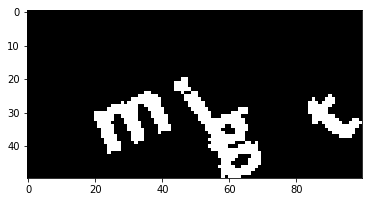

In [168]:
show(generate_captcha(generate_text()))

In [181]:
a = generate_captcha(generate_text())
b = generate_captcha(generate_text())

In [226]:
def loss(target, image):
    return (target != image).mean()

loss(a, a), loss(a, b), loss(b, b)

(0.0, 0.1278, 0.0)

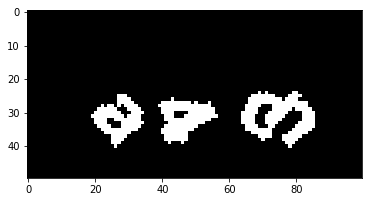

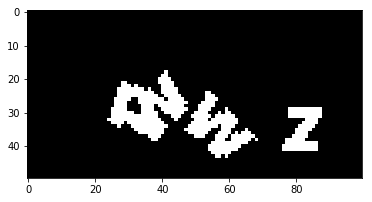

(None, None)

In [190]:
show(a), show(b)

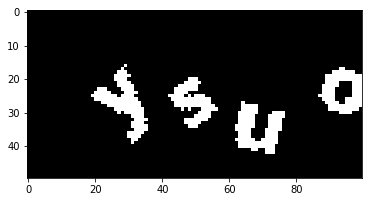

step: 200 ['y:0.08', 'y:0.08', 'y:0.08', 'y:0.08', 'y:0.08']
step: 200 ['s:0.08', 's:0.08', 's:0.08', 's:0.08', 's:0.08']
step: 200 ['u:0.08', 'u:0.08', 'u:0.08', 'u:0.08', 'u:0.08']
step: 200 ['o:0.08', 'o:0.08', 'o:0.08', 'o:0.08', 'o:0.08']


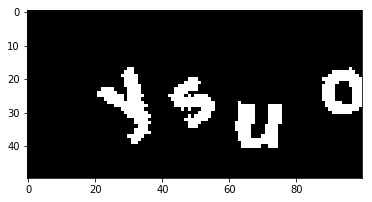

0.027799999999999998

In [212]:
Entity = collections.namedtuple('Entity', ['config', 'score'])


def entity_from_config(config):
    text_config = [config]
    image = render_captcha(text_config)
    score = loss(target=target, image=image)
    return Entity(config, score)


def generate_entity(pos, letter):
    config = generate_letter_config(pos, letter)
    return entity_from_config(config)


def generate_population(pos):
    return [generate_entity(pos, letter) for letter in ALPHABET]


def mutate(population):
    return [mutate_entity(e) for e in population]


def mutate_entity(e):
    mode = np.random.randint(2)
    new_config = e.config._asdict()
    if mode == 0:
        new_config['letter'] = np.random.choice(ALPHABET)
    elif mode == 1:
        new_config = generate_letter_config(e.config.pos, e.config.letter)._asdict()
    elif mode == 2:
        new_config['x'] = e.config.x + 1
    elif mode == 3:
        new_config['x'] = e.config.x - 1
    elif mode == 4:
        new_config['y'] = e.config.y + 1
    elif mode == 5:
        new_config['y'] = e.config.y - 1
    elif mode == 6:
        new_config['rotation'] = e.config.rotation + 1
    elif mode == 7:
        new_config['rotation'] = e.config.rotation - 1
    config = LetterConfig(**new_config)
    return entity_from_config(config)


def solve(target, n=201):
    text_config = []
    for pos in range(4):
        population = generate_population(pos)
        for i in range(n):
            population.extend(mutate(population))
            population.extend(generate_population(pos))
            population = list(sorted(population, key=lambda e: e.score))[:10]
            if i % 10 == 0:
                print('step:', i,
                      ['{}:{:.2f}'.format(e.config.letter, e.score) for e in population[:5]],
                      end='\r')
        print()
        text_config.append(population[0].config)
    return text_config
    
target = generate_captcha(generate_text())
show(target)
config = solve(target)
img = render_captcha(config)
show(img)
loss(image=img, target=target)

In [221]:
captchas = get_captchas()

In [ ]:
np.random.shuffle(captchas)
for captcha in captchas:
    print('-' * 100)
    target = preprocess(captcha)
    show(target)
    config = solve(target)
    img = render_captcha(config) 
    show(img)
    print(loss(target=target, image=img))
    show(img ^ target)
    show(np.maximum(0, target - img))

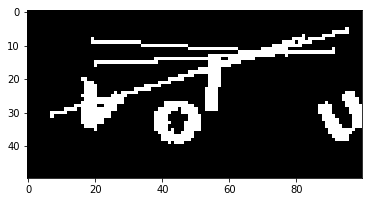

step: 200 ['v:6.340', 'z:6.360', '4:6.440', 's:6.480', 'r:6.480']
step: 200 ['o:4.680', 'u:5.160', 'n:5.180', 'b:5.260', 'c:5.280']
step: 200 ['l:3.940', 'f:4.040', 'r:4.140', 't:4.400', 'i:4.400']
step: 200 ['n:2.700', 'u:2.960', 'v:3.120', 'a:3.140', 'z:3.180']
2.7


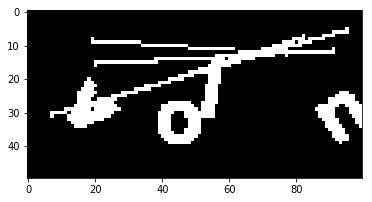

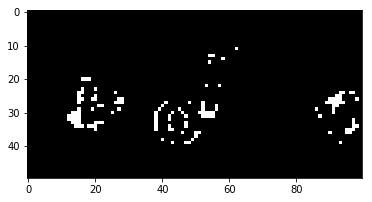

In [238]:
Entity = collections.namedtuple('Entity', ['pos', 'letter', 'x', 'y', 'rotation', 'score'])

target = None
solution = []

def generate_entity(pos, letter=None):
    d = 10
    r = 60
    return update_score(Entity(
        pos=pos,
        letter=letter or np.random.choice(ALPHABET),
        x=8 + pos * 23 + np.random.randint(-d, d),
        y=10 + np.random.randint(-d, d),
        rotation=np.random.randint(-r, r),
        score=None))

def loss(target, image):
    return (target != image).mean() * 100

def update_score(e):
    image = render_captcha(solution + [e])
    return e._replace(score=loss(target=target, image=image))

def mutate(e):
    mode = np.random.randint(7)
    mode = 6
    if mode == 0:
        e = e._replace(x=e.x + 1)
    elif mode == 1:
        e = e._replace(x=e.x - 1)
    elif mode == 2:
        e = e._replace(y=e.y - 1)
    elif mode == 3:
        e = e._replace(y=e.y - 1)
    elif mode == 4:
        e = e._replace(rotation=e.rotation - 1)
    elif mode == 5:
        e = e._replace(rotation=e.rotation - 1)
    elif mode == 6:
        e = generate_entity(e.pos, e.letter)
    return update_score(e)

def solve(target_, n=201):
    global solution
    global target
    target = target_
    solution = []
    for pos in range(4):
        letters = [generate_entity(pos, letter) for letter in ALPHABET]
        for i in range(n):
            for j, letter in enumerate(letters):
                new_letter = mutate(letter)
                if new_letter.score < letter.score:
                    letters[j] = new_letter
            if i % 10 == 0:
                letters = list(sorted(letters, key=lambda e: e.score))
                print('step:', i,
                      ['{}:{:.3f}'.format(e.letter, e.score) for e in letters[:5]],
                      end='\r')
        print()
        solution.append(min(letters, key=lambda e: e.score))
    return solution

def run(target):
    show(target)
    config = solve(target)
    img = render_captcha(config)
    print(loss(image=img, target=target))
    show(img)
    show(target != img)

target = preprocess(captchas[334])
run(target)

In [245]:
Entity = collections.namedtuple('Entity', ['letter', 'x', 'y', 'rotation'])

def generate_entity(pos, letter=None):
    d = 10
    r = 60
    return Entity(
        letter=letter or np.random.choice(ALPHABET),
        x=8 + pos * 23 + np.random.randint(-d, d),
        y=10 + np.random.randint(-d, d),
        rotation=np.random.randint(-r, r))

letter = 'd'
imgs = [render_captcha([generate_entity(0, letter)]) for _ in range(1000)]

In [247]:
pcs = [preprocess(c) for c in captchas]

In [260]:
spcs = []
for pc in pcs:
    (score, img) = min(((loss(pc, img), img) for img in imgs), key=lambda ab: ab[0])
    spcs.append((score, pc, img))

5.32


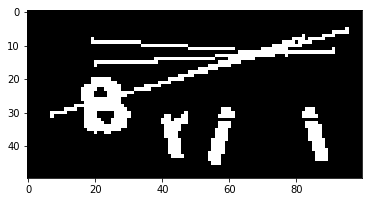

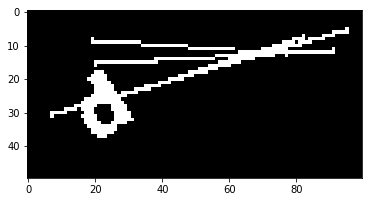

5.38


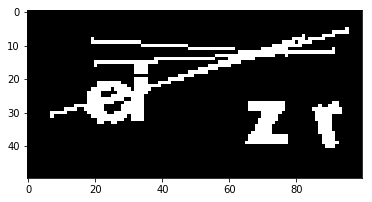

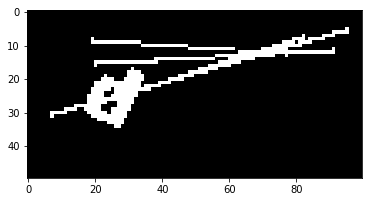

5.46


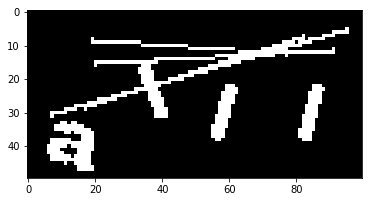

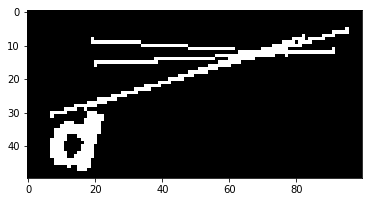

5.68


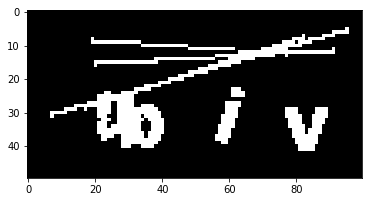

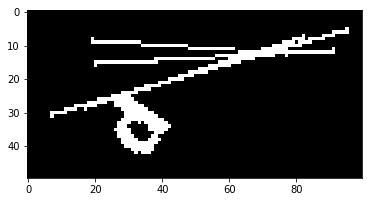

5.7


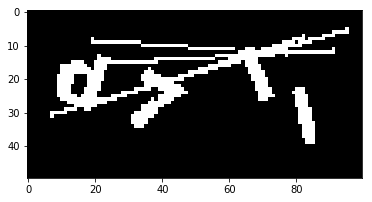

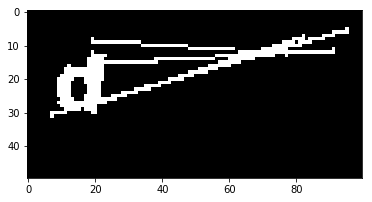

5.72


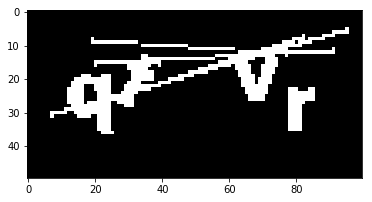

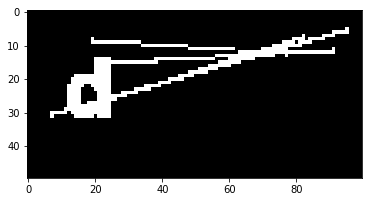

5.84


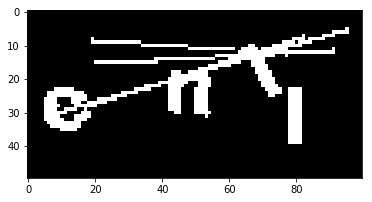

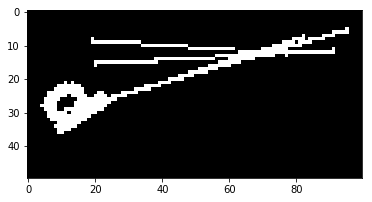

5.9


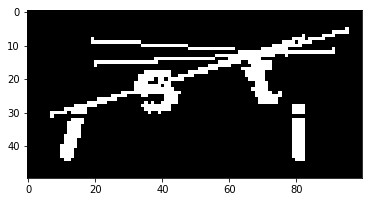

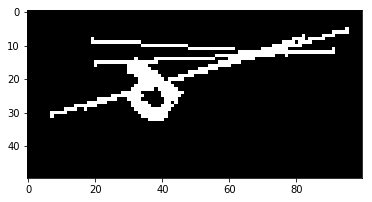

5.94


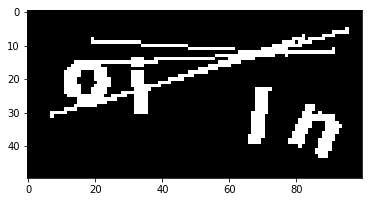

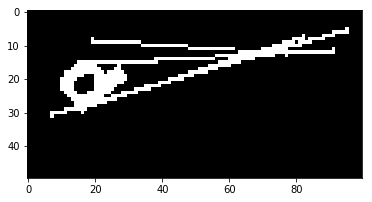

6.04


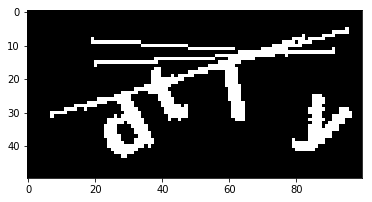

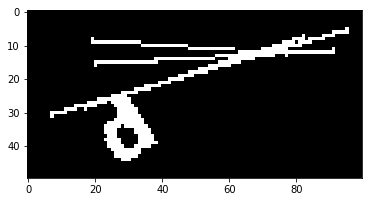

In [264]:
for score, pc, img in sorted(spcs, key=lambda abc: abc[0])[:10]:
    print(score)
    show(pc)
    show(img)

In [268]:
from skimage import segmentation
from skimage.morphology import watershed
from skimage.feature import peak_local_max

# Generate an initial image with two overlapping circles
x, y = np.indices((80, 80))
x1, y1, x2, y2 = 28, 28, 44, 52
r1, r2 = 16, 20
mask_circle1 = (x - x1) ** 2 + (y - y1) ** 2 < r1 ** 2
mask_circle2 = (x - x2) ** 2 + (y - y2) ** 2 < r2 ** 2

image = np.logical_or(mask_circle1, mask_circle2)
# Now we want to separate the two objects in image
# Generate the markers as local maxima of the distance
# to the background
from scipy import ndimage
distance = ndimage.distance_transform_edt(image)
local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3, 3)), labels=image)
markers = morphology.label(local_maxi)
labels_ws = watershed(-distance, markers, mask=image)
# Transform markers image so that 0-valued pixels are to
# be labelled, and -1-valued pixels represent background
markers[~image] = -1
labels_rw = segmentation.random_walker(image, markers)

TypeError: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

In [269]:
import cv2

ModuleNotFoundError: No module named 'cv2'